# Steady-state conduction in a lengthwise-insulated rod with internal heat production

In this notebook we present the code behind [heat transfer in a rod tutorial](https://github.com/camillejr/fluid-dynamics-and-transport-phenomena/blob/master/transport-phenomena-with-Python/example-heat-transfer-in-a-rod.pdf).

We compute the analytic solution and then compare that to few numerical solutions of the governing ODE.

In [1]:
import math
from matplotlib import pyplot as plt
import numpy
import matplotlib.patches as patches

nfont = {"name": "cmr10", "style": "normal", "weight": "normal"}
ifont = {"name": "cmr10", "style": "normal", "weight": "normal"}
demand_col = '#282850'
renewables_col = '#f44242'
background_col = "#f9f7f2"

fontsize_title = 20
fontsize_axes = 16
fontsize_text = 16

## Analytic solution

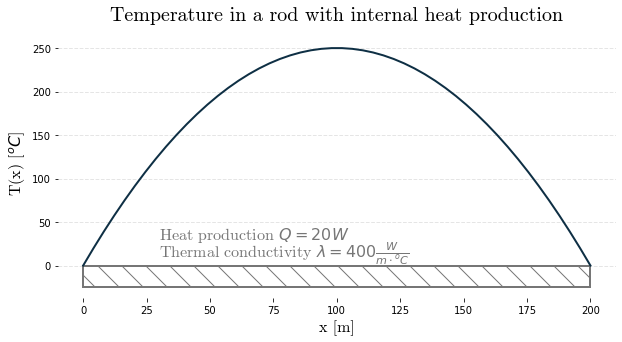

In [2]:
# Data:
T0 = 0 # deg C
L = 200 # m

# Internal heat production:
Q = 20 # Watt

# Thermal conductivity:
lam = 400 # W/(m*C)

# Bar length discretization:
N = 50

x = numpy.linspace(0, L, N)
T = - Q/(2*lam) * (x**2 - L * x) + T0

# Plot graph:
figure = plt.figure(figsize=(10, 5))
ax1 = figure.add_subplot(1,1,1)
# plt.title('Temperature distribution in $^oC$ in a rod with internal heat production of ' + str(Q) + ' Watt')
plt.xlabel(r'x [m]', fontsize=fontsize_axes, **nfont)
plt.ylabel(r'T(x) [$^o C$]', fontsize=fontsize_axes, **nfont)
plt.title(r'Temperature in a rod with internal heat production', fontsize=fontsize_title, **nfont)
plt.xlim(-0.05*L, 1.05*L)
plt.ylim(-0.15*max(T), 1.1*max(T))
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.margins(x=0)
plt.rcParams['axes.xmargin'] = 0

# Line colour:
lineColour = '#0e2f44'

# Bar colour:
barColour = '#767676'

# Help lines:
helpLines = "#e5e5e5"

ax1.add_patch(
    patches.Rectangle(
        (0, -0.1*max(T)),   # (x,y)
        L,          # width
        0.1*max(T),          # height
        Fill=False,
        edgecolor=barColour,
        linewidth=2.0,
        hatch='\\'
    )
)

# To plot the line:
plt.plot(x, T, color=lineColour, linestyle='-', linewidth=2.0, zorder=1)
ax1.text(30,30, r'Heat production $Q = 20 W$', fontsize=fontsize_text, color=barColour, **ifont)
ax1.text(30,10, r'Thermal conductivity $\lambda = 400 \frac{W}{m \cdot ^oC}$', fontsize=fontsize_text, color=barColour, **ifont)

# Plot helping lines for the temperature:
for y in numpy.arange(min(T), 1.1*max(T), 50):
    plt.plot([-0.05*L, 1.05*L], [y, y], "--", lw=1, color=helpLines, zorder=-1)

# Save plot:
filename = 'conduction-rod.png'
plt.savefig(filename, dpi = 500)
plt.show()
plt.close()
